In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import os

## 데이터 전처리

In [2]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/activity_consume_final_data.csv')

# TIME_SLOT 숫자로 변환
time_slot_mapping = {
    'dawn': 0,
    'morning': 1,
    'afternoon': 2,
    'night': 3
}
# 매핑 적용
df['TIME_SLOT'] = df['TIME_SLOT'].map(time_slot_mapping)

# 혼잡도 숫자로 변환
congestion_mapping = {
    'LOW': 0,
    'MEDIUM': 1,
    'HIGH': 2,
    'VERY_HIGH': 3
}
# 매핑 적용
df['CONGESTION_LEVEL'] = df['CONGESTION_LEVEL'].map(congestion_mapping)

# NaN 포함된 행 제거
df = df.dropna()


In [3]:
# input과 label 분리
input = df[['IS_WEEKEND', 'TIME_SLOT', 'AVG_PAYMENT_AMT', 'ROAD_NM_CD', 'ACTIVITY_TYPE_CD']]
label = df[['CONGESTION_LEVEL']].squeeze()  # 1차원 변환

# train:test=8:2
X_train, X_test, y_train, y_test = train_test_split(
    input,
    label,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 데이터 shape 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7910, 5)
X_test shape: (1978, 5)
y_train shape: (7910,)
y_test shape: (1978,)


In [4]:
# NaN 확인
print(X_train.isna().sum())
print('--------------------------------')
print(X_test.isna().sum())
print('--------------------------------')
print(y_train.isna().sum())
print('--------------------------------')
print(y_test.isna().sum())

IS_WEEKEND          0
TIME_SLOT           0
AVG_PAYMENT_AMT     0
ROAD_NM_CD          0
ACTIVITY_TYPE_CD    0
dtype: int64
--------------------------------
IS_WEEKEND          0
TIME_SLOT           0
AVG_PAYMENT_AMT     0
ROAD_NM_CD          0
ACTIVITY_TYPE_CD    0
dtype: int64
--------------------------------
0
--------------------------------
0


## 3가지 머신러닝 분류기 학습 및 성능 평가

Model :  RFC
Acc on test set : 0.9075
Recall on test set: 0.9075
Precision on test set: 0.8520
F1 Score  on test set: 0.8759
Model saved to /content/drive/MyDrive/ML_models/RFC_acc_0.9074823053589485.joblib


100%|===================| 7899/7912 [03:06<00:00]       

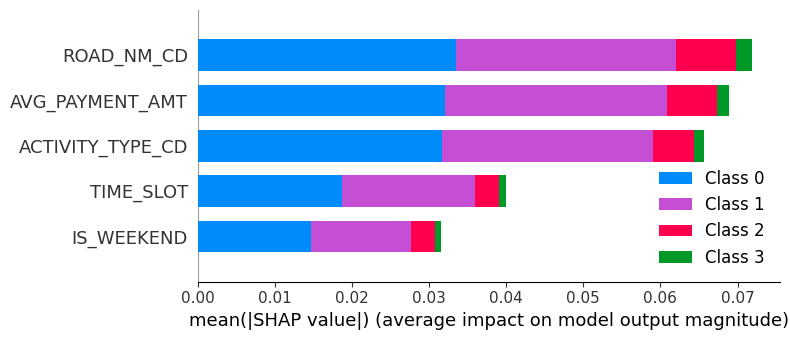


Calculating feature importance for RFC


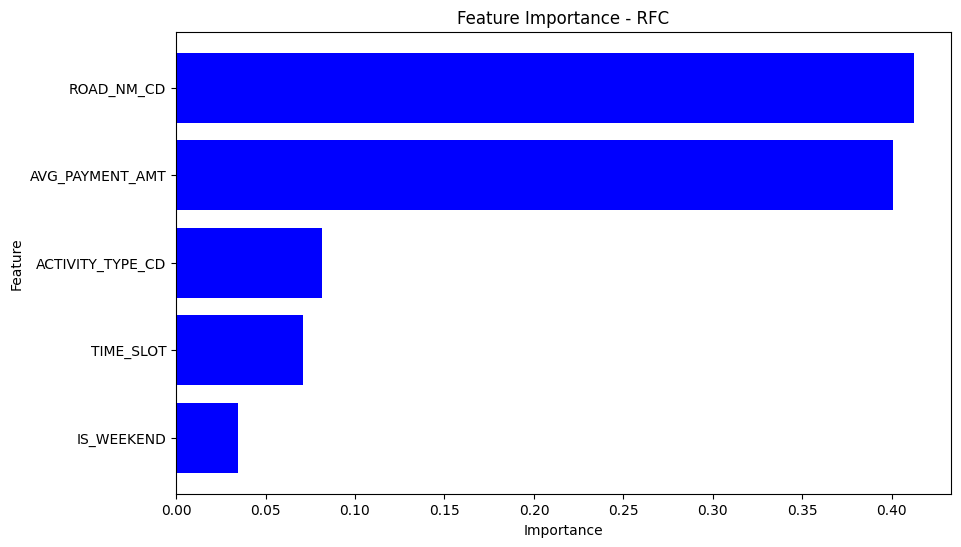

Model :  ETC
Acc on test set : 0.8600
Recall on test set: 0.8600
Precision on test set: 0.8526
F1 Score  on test set: 0.8562
Model saved to /content/drive/MyDrive/ML_models/ETC_acc_0.8599595551061678.joblib


100%|===================| 7881/7912 [04:32<00:01]       

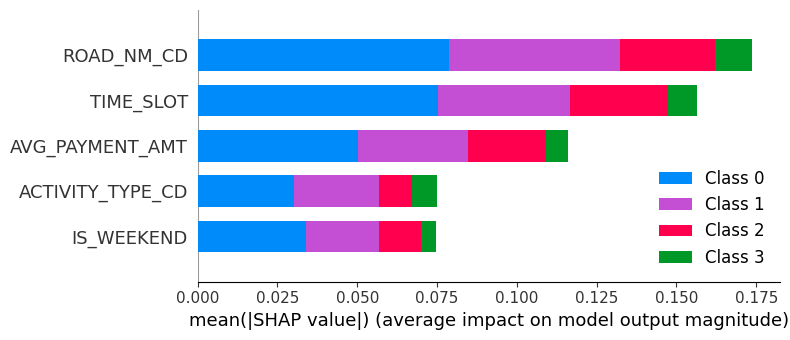


Calculating feature importance for ETC


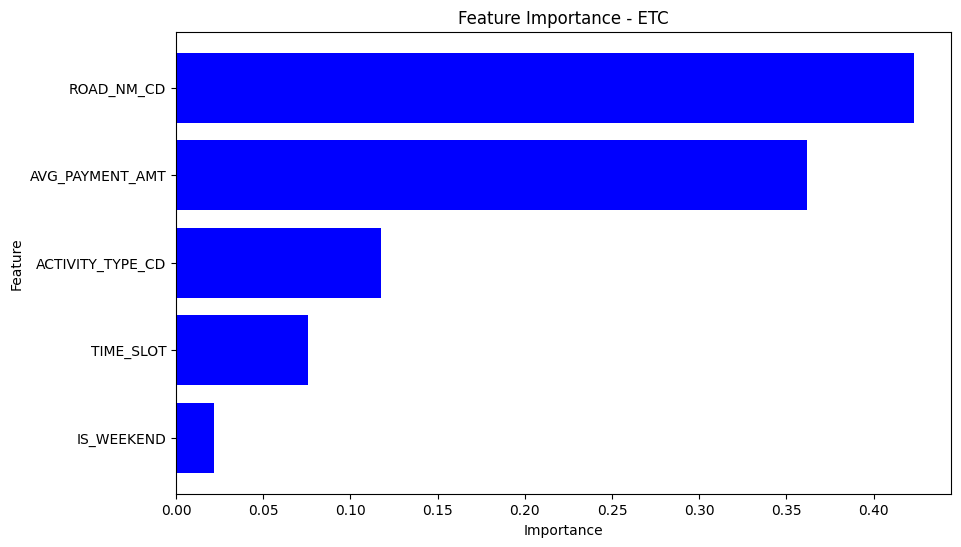

Model :  XGB


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:47:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Acc on test set : 0.9100
Recall on test set: 0.9100
Precision on test set: 0.8697
F1 Score  on test set: 0.8842
Model saved to /content/drive/MyDrive/ML_models/XGB_acc_0.910010111223458.joblib


100%|===================| 7886/7912 [01:24<00:00]       

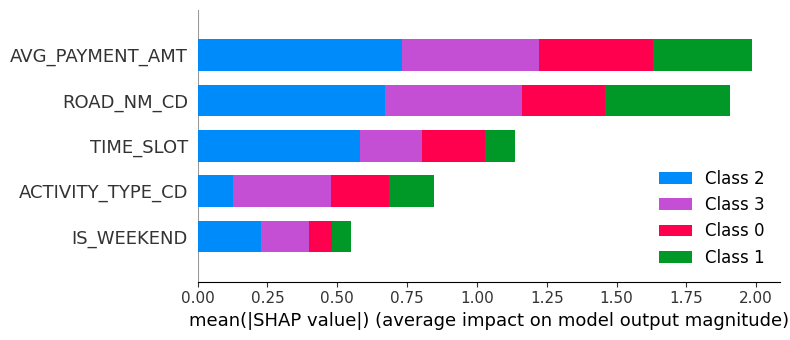


Calculating feature importance for XGB


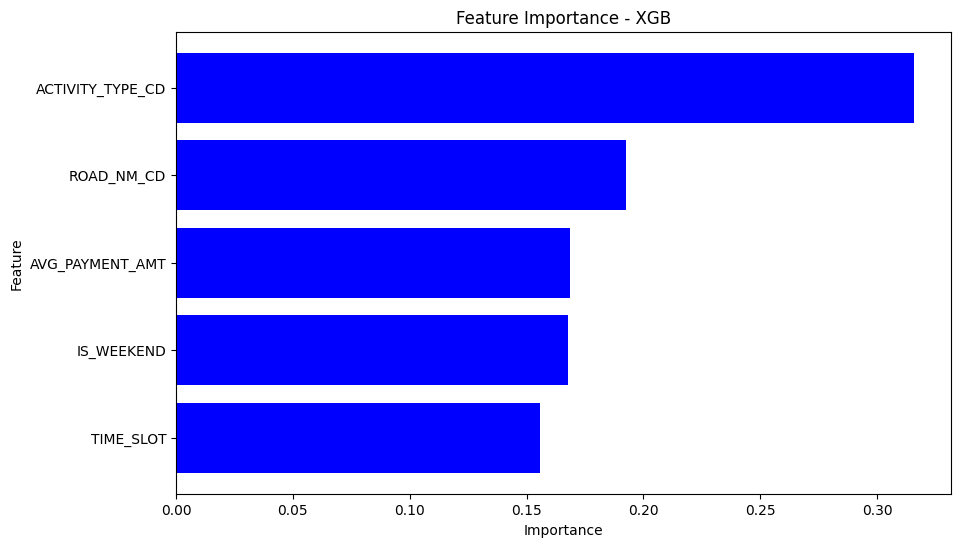

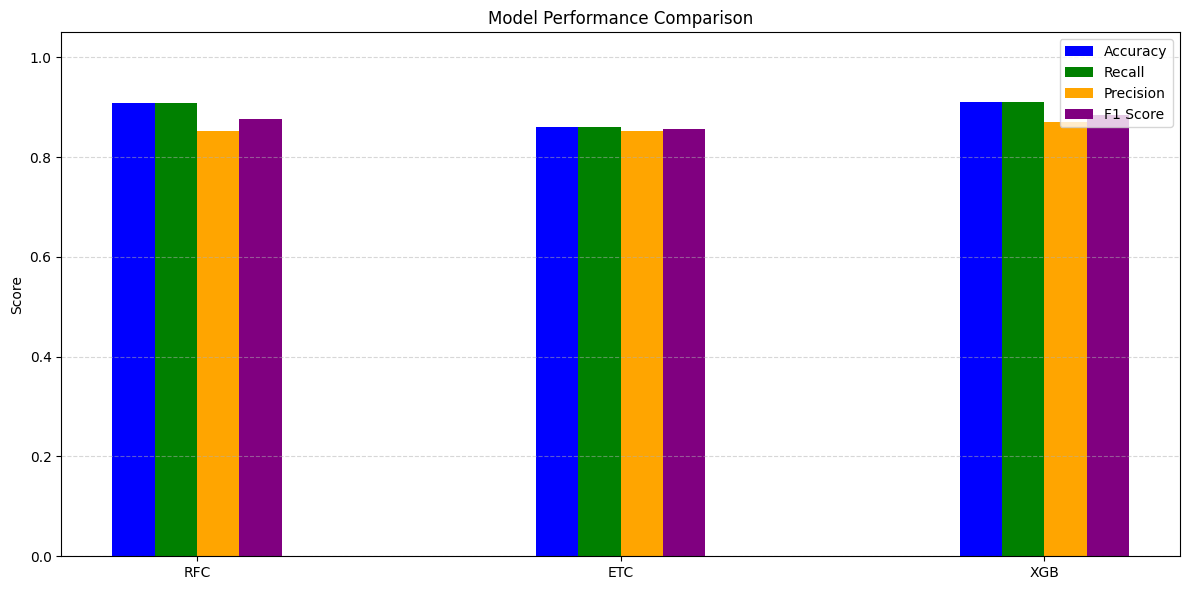

In [5]:
models = {
    'RFC': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, class_weight='balanced'),
    'ETC': ExtraTreesClassifier(random_state=42, n_estimators=100, max_depth=20, class_weight='balanced'),
    'XGB': XGBClassifier(eval_metric='mlogloss', random_state=42, n_estimators=100, class_weight='balanced'),
}

feature_names = ['IS_WEEKEND', 'TIME_SLOT', 'AVG_PAYMENT_AMT', 'ROAD_NM_CD', 'ACTIVITY_TYPE_CD']

# 성능 지표 저장용 리스트
accuracies = []
recalls = []
precisions = []
f1_scores = []

# plot 저장 디렉토리
save_plot_dir = "/content/drive/MyDrive/plots"
os.makedirs(save_plot_dir, exist_ok=True)

for model_name, model in models.items():
    print('===================================================================')
    print('Model : ', model_name)

    model.fit(X_train, y_train)

    # 테스트 세트에서 최적 모델 평가
    pred_labels = model.predict(X_test)

    model_acc = accuracy_score(y_test, pred_labels)
    recall = recall_score(y_test, pred_labels, average='weighted')
    precision = precision_score(y_test, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_test, pred_labels, average='weighted')

    # 성능 리스트에 저장
    accuracies.append(model_acc)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

    print(f"Acc on test set : {model_acc:.4f}")
    print(f"Recall on test set: {recall:.4f}")
    print(f"Precision on test set: {precision:.4f}")
    print(f"F1 Score  on test set: {f1:.4f}")

    # 모델 저장
    save_model_dir = "/content/drive/MyDrive/ML_models"
    os.makedirs(save_model_dir, exist_ok=True)
    save_path = f"{save_model_dir}/{model_name}_acc_{model_acc}.joblib"
    joblib.dump(model, save_path)
    print(f"Model saved to {save_path}")

    # SHAP
    try:
          explainer = shap.TreeExplainer(model, X_train)
          shap_values = explainer(X_test, check_additivity=False)

          # bar 플롯
          shap.summary_plot(shap_values, X_test, plot_type="bar")
          plt.title(f"SHAP Summary Plot (Bar) - {model_name}")
          plt.savefig(os.path.join(save_plot_dir, f"shap_summary_bar_{model_name}.png"), dpi=300)
          plt.close()

          # # dot 플롯 - 다중 클래스 분류에서는 클래스 별로 뽑아야 함
          # shap.summary_plot(shap_values, X_test, plot_type="dot")
          # plt.title(f"SHAP Summary Plot (dot) - {model_name}")
          # plt.tight_layout()
          # plt.savefig(os.path.join(save_plot_dir, f"shap_summary_dot_{model_name}.png"), dpi=300)
          # plt.close()

    except Exception as e:
        print(f"SHAP 분석 실패: {e}")

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        print(f"\nCalculating feature importance for {model_name}")
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance) # 중요도 오름차순 정렬
        sorted_features = [feature_names[i] for i in sorted_idx]

        # feature importance 시각화
        plt.figure(figsize=(10, 6))
        plt.barh(sorted_features, feature_importance[sorted_idx], color='blue')  # Horizontal bar chart
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.savefig(os.path.join(save_plot_dir, f"feature_importance_{model_name}.png"), dpi=300)
        plt.show()

# 각 성능지표 바에 사용할 색상
colors = ['blue', 'green', 'orange', 'purple']

x = np.arange(len(models))  # 모델 인덱스
width = 0.1

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy', color=colors[0])
plt.bar(x - 0.5*width, recalls, width, label='Recall', color=colors[1])
plt.bar(x + 0.5*width, precisions, width, label='Precision', color=colors[2])
plt.bar(x + 1.5*width, f1_scores, width, label='F1 Score', color=colors[3])

plt.xticks(x, models.keys())
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(save_plot_dir, f"model_performance_comparison.png"), dpi=300)
plt.show()
